In [36]:
import seaborn as sns
import json
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt

In [37]:
def extend(lst, desired_length, fill_value=None):
    return lst + [fill_value] * (desired_length - len(lst))

In [47]:
# Angle between two vectors in degrees.
def vang(a, b): 
    return np.arccos(a.dot(b)) / np.pi * 180

# Vector from two angles
def vec(x):
    return np.array([np.cos(x[0]) * np.sin(x[1]), np.sin(x[0]) * np.sin(x[1]), np.cos(x[1])])

# convert in-game angles to radian coordiantes
def gamea(a, b):
    return [b / 180 * np.pi, (90 - a) / 180 * np.pi]

# pixels distance between two vectors (a,b) and (c,d) defined by in-game angles.
def points(a, b, c, d):
    return vang(vec(gamea(a, b)), vec(gamea(c, d))) / 0.022

def vector_length(x, y):
    return np.sqrt(x * x + y * y)

def diff(a, b):
#     return sum([abs(x[0] - x[1]) for x in zip(a, b)])
#     return pow(sum(d), 0.5)
    d = [pow(x[0] - x[1], 2) for x in zip(a, b)]
    return sum([max(x - 3, 0) for x in d])

def dist_score(x):
    return np.exp(-0.0004 * np.power(x, 2))

def rc_score(r1, r2):
    return 100 * np.mean([dist_score(vector_length(r1['x'][i] - r2['x'][i], r1['y'][i] - r2['y'][i])) for i in range(len(r1['x']))])

magic = 1.0

def median_delta_recoil(rc):
    mx = [0]
    my = [0]
    x = 0
    y = 0
    n = len(rc[0]['x'])
    for i in range(1, n):
        dx = []
        dy = []
        for r in rc:
            dx.append(r['x'][i] - r['x'][i-1])
            dy.append(r['y'][i] - r['y'][i-1])
        x += np.median(dx)
        y += np.median(dy)
        mx.append(np.round(x, 1))
        my.append(np.round(y, 1))
    return mx, my

def mean_recoil(rc, mm):
    mx = [0]
    my = [0]
    x = 0
    y = 0
    n = len(rc[0]['x'])
    for i in range(1, n):
        dx = []
        dy = []
        for r in rc:
            dx.append(r['x'][i])
            dy.append(r['y'][i])
        x = np.mean(dx)
        y = np.mean(dy)
        mx.append(np.round(x * magic, 1))
        my.append(np.round(y * magic, 1))
    return mx, my

In [39]:
def rpm(name):
  with open('../client/specs.json') as f:
    specs = json.load(f)
  for x in specs:
    if x['name'] == name:
      return x['rpm']
  return 1

In [50]:
def multiplier(name):
  with open('../client/specs.json') as f:
    specs = json.load(f)
  for x in specs:
    if x['name'] == name:
      return x['multiplier']
  return 1

In [49]:
np.round(points(13.0, 37.10, -0.4, 37.36), 2)

609.2

In [41]:
rc = [
   {"weapon":"r99","barrel":0,"stock":0,"comment":"r99_1_577.92.png","x":[0,9.3,11.6,1.2,2.3,5.8,23.2,33.6,54.4,60.2,45.2,37.1,35.9,30.1,39.4,57.9,71.8,91.5,69.5,57.9,42.8,31.3,17.4,28.9,38.2,59.1,75.3,68.3,49.8,53.3],"y":[0,-30.1,-54.4,-82.2,-126.2,-184.1,-223.5,-266.3,-302.2,-338.1,-378.6,-413.4,-445.8,-480.5,-500.2,-496.7,-516.4,-506,-538.4,-534.9,-540.7,-545.4,-547.7,-566.2,-552.3,-546.5,-544.2,-556.9,-560.4,-575.5]},
   {"weapon":"r99","barrel":0,"stock":0,"comment":"r99_2_560.51.png","x":[0,3.4,4.6,-1.1,-8,11.5,24.1,43.5,47,48.1,32.1,18.3,14.9,11.5,20.6,27.5,35.3,40.6,35.5,16,-8,-11.7,-28.7,-12.6,6.9,29.5,29.8,14.9,-3.4,10.3],"y":[0,-30.9,-55,-82.5,-120.3,-161.6,-209.7,-237.2,-283.1,-308.3,-343.8,-383.9,-408,-445.8,-447,-461.9,-478.6,-483.2,-489.4,-495.1,-510,-521.8,-529.5,-528.3,-520.3,-524.4,-532.9,-544.4,-539.8,-560.4]},
   {"weapon":"r99","barrel":0,"stock":0,"comment":"r99_3_597.44.png","x":[0,8.1,11.1,6.1,7.1,20.2,31.3,42.4,43.4,47.4,39.3,19.2,15.1,11.1,10.1,18.2,36.3,61.5,37.3,17.1,-4,-17.1,-23.2,-15.1,1,18.2,28.2,15.1,4,16.1],"y":[0,-32.3,-61.5,-83.7,-126.1,-190.7,-236.1,-263.3,-306.7,-341,-374.3,-405.5,-432.8,-476.2,-485.9,-492.3,-494.3,-496.3,-525.6,-526.6,-529.6,-531.6,-535.7,-543.8,-548.8,-547.8,-559.9,-560.9,-585.1,-597.2]}
]
print(len(rc[-1]['x']))

30


"x": [0, 5.1, 6.6, 1.5, 0.3, 9.1, 19.1, 29.1, 35.2, 37.9, 28.4, 18.2, 16.0, 12.8, 17.1, 25.2, 34.9, 47.1, 34.6, 22.1, 7.5, 0.6, -8.4, 0.3, 11.2, 26.0, 32.4, 23.9, 12.3, 19.4],
"y": [0, -22.7, -41.6, -60.4, -90.7, -130.5, -162.9, -186.6, -217.1, -240.3, -266.9, -292.7, -313.1, -341.3, -348.7, -353.1, -362.4, -361.5, -378.0, -378.8, -384.5, -389.0, -392.5, -398.7, -394.5, -393.9, -398.3, -404.5, -410.1, -421.7],
"time_points": [0, 55, 111, 166, 222, 277, 333, 388, 444, 500, 555, 611, 666, 722, 777, 833, 888, 944, 1000, 1055, 1111, 1166, 1222, 1277, 1333, 1388, 1444, 1500, 1555, 1611],
30 30 30 30


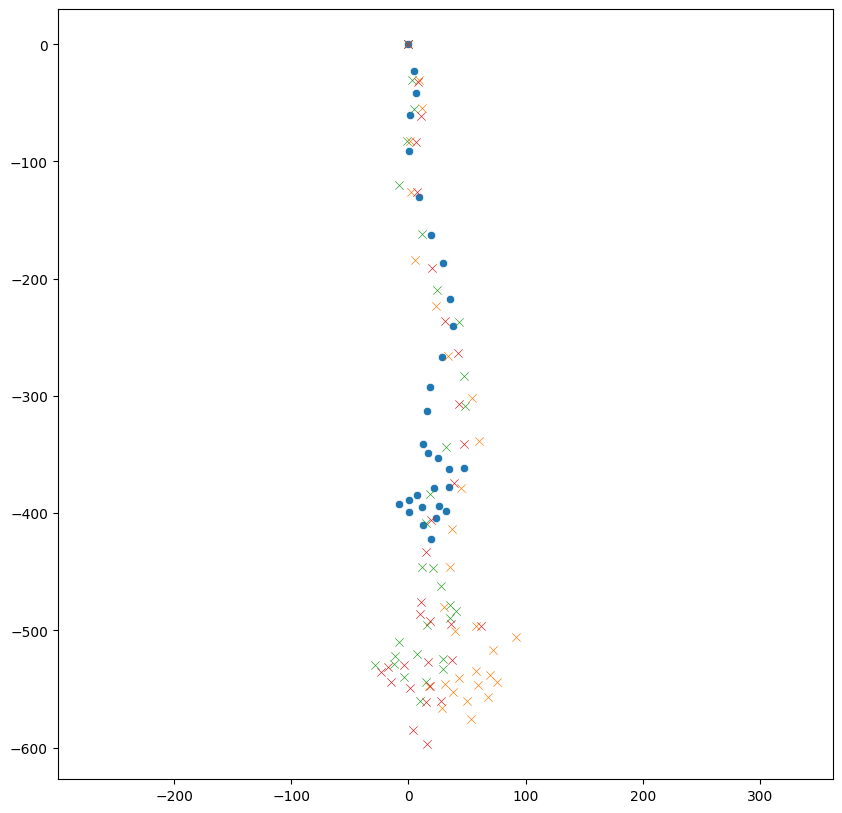

In [52]:
_, ax = plt.subplots(figsize=(10,10))
plt.axis('equal')
x, y = mean_recoil(rc)
sns.scatterplot(ax=ax, x=x, y=y)

for r in rc:
    sns.scatterplot(ax=ax, x=r['x'], y=r['y'], marker='x')
n = len(rc[0]['x'])
w = rc[0]['weapon']
r = rpm(w)
magic = multiplier(w)
t = [int(i * 60.0 * 1000 / r) for i in range(n)]

s = json.dumps({
    'x': x,
    'y': y,
    'time_points': t,
    })
print(s.replace('], ','],\n')[1:-1] + ',')
print(n, len(x), len(y), len(t))

In [43]:
if len(rc) > 2:
  for i in range(len(rc)):
    sub = rc[:i] + rc[i+1:]
    tx, ty = mean_abs_recoil(sub)
    print('w/o', i, ':', np.mean([rc_score(r, {'x': tx, 'y': ty}) for r in sub]))
else:
  print('not enough patterns')
# tx, ty = mean_delta_recoil(rc)
# print('mean_delta_recoil', np.mean([rc_score(r, {'x': tx, 'y': ty}) for r in rc]))
# tx, ty = median_delta_recoil(rc)
# print('median_delta_recoil', np.mean([rc_score(r, {'x': tx, 'y': ty}) for r in rc]))
# tx, ty = mean_delta2_recoil(rc)
# print('mean_delta2_recoil', np.mean([rc_score(r, {'x': tx, 'y': ty}) for r in rc]))

w/o 0 : 93.64773602246447
w/o 1 : 90.06882927275355
w/o 2 : 84.43293794633166


In [44]:
k = len(rc) - 1
err = [0] * k
# maxerr = [0] * len(rc)
# minerr = [100000000] * len(rc)
tx, ty = mean_abs_recoil(rc)
for i in range(200):
    t = np.random.permutation(rc)
    for j in range(k):
        x, y = mean_recoil(t[:j+1])
        d = diff(x, tx) + diff(y, ty)
        err[j] += d
        # minerr[j] = min(minerr[j], d)
        # maxerr[j] = max(maxerr[j], d)

bd = 0
bi = 0
for i, r in enumerate(rc):
    print(i, r['comment'], rc_score(r, {'x': tx, 'y': ty}))
    d = diff(r['x'][:n], tx) + diff(r['y'][:n], ty)
    if d > bd:
        bd = d
        bi = i
print('bad', bi, rc[bi]['comment'])
plt.yscale('log')
plt.ylim(1, None)
sns.lineplot(x=range(k), y=err)
d = err[-2] / err[0]
d, d < 0.01, [rc_score(r, {'x': tx, 'y': ty}) for r in rc], 'err', err

NameError: name 'mean_recoil' is not defined